In [485]:
import os
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import copy
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aru10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aru10\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aru10\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [145]:
def importDocument(path):
    required = ["comp.graphics", "sci.med", "talk.politics.misc", "rec.sport.hockey", "sci.space"]
    content = {}
    file_list = {}
    for info in os.walk(path):
        folder_idx = info[0].find("/", 8)
        folder_name = info[0][folder_idx+1::]
        if folder_name in required:
            filenames = info[2]
            files_content = {}
            file_name = []
            for file in filenames:
                f = open(info[0]+"/"+file)
                file_name.append(file)
                files_content[file] = []
                lines = f.readlines()
                for line in lines:
                    files_content[file].append(line)
            content[folder_name] = files_content
            file_list[folder_name] = file_name
    return content, file_list

In [146]:
def onlyWords(documents):
    for key, content in documents.items():
        for filename, value in content.items():
            buff = []
            for line in range(len(value)):
                if len(value[line].strip()) != 0:
                    linetoken = nltk.RegexpTokenizer(r"\w+").tokenize(value[line])
                    linetoken = [i.lower() for i in linetoken]
                    if len(linetoken) != 0:
                        buff.append(linetoken)
            documents[key][filename] = buff
    return documents

In [147]:
def removeStopWords(documents):
    stop_words = set(stopwords.words('english'))
    for key, content in documents.items():
        for filename, value in content.items():
            for line in range(len(value)):
                value[line] = [i for i in value[line] if not i in stop_words]
            documents[key][filename] = value
    return documents

In [148]:
def lemmatization(documents):
    lemmatizer = WordNetLemmatizer()
    for key, content in documents.items():
        for filename, value in content.items():
            for line in range(len(value)):
                value[line] = [lemmatizer.lemmatize(i) for i in value[line]]
    return documents

In [149]:
def removeUnderscore(documents):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    for key, content in documents.items():
        for filename, value in content.items():
            for idx, line in enumerate(value):
                add = []
                for i, word in enumerate(line):
                    if not word.isalnum():
                        change = word.replace("_"," ").strip()
                        change = nltk.RegexpTokenizer(r"\w+").tokenize(change)
                        change = [i.lower() for i in change]
                        change = [i for i in change if not i in stop_words]
                        change = [lemmatizer.lemmatize(i) for i in change]
                        add += change
                        line[i] = ""
                line += add
                value[idx] = [word for word in line if len(word) > 0]
            documents[key][filename] = [line for line in value if len(line) > 0]
    
    for key, content in documents.items():
        for filename, value in content.items():
            buffer = []
            for line in value:
                buffer += line
            documents[key][filename] = buffer
        
    return documents

In [166]:
def uniqueWords(documents):
    class_word_list = {}
    class_bow = {}
    for key, content in documents.items():
        bow = {}
        word_list = {}
        buffer = []
        for i, t in enumerate(content.items()):
            filename = t[0]
            value = t[1]
            bow[filename] = {}
            buffer += value
            for word in value:
                if word not in bow[filename]:
                    bow[filename][word] = 1
                else:
                    bow[filename][word] += 1
        
        unique = sorted(list(set(buffer)))
        for i, word in enumerate(unique):
            word_list[word] = i
        class_bow[key] = bow
        class_word_list[key] = word_list
    return class_word_list, class_bow

In [338]:
def TF(word_list, word_dict, x1):
    class_tf = {}
    for key, value in word_dict.items():
        tf = {}
        tot = 0
        for filename, words in value.items():
            if filename in x1:
                for word, count in words.items():
                    if word not in tf:
                        tf[word] = count
                    else:
                        tf[word] += count
                    tot += count
        
        for word, _ in tf.items():
            tf[word] = tf[word]/tot
        
        class_tf[key] = tf
        
    return class_tf

In [334]:
def CF(word_list):
    all_words = {}
    icf = {}
    for label, val in word_list.items():
        for word, count in val.items():
            if word not in all_words:
                all_words[word] = [label]
            else:
                if label not in all_words[word]:
                    all_words[word].append(label)

    for word, labels in all_words.items():
        all_words[word] = len(labels)
        icf[word] = np.log10((5/all_words[word]))
        
    return all_words, icf

In [268]:
def TFICF(class_tf, class_icf):
    tf_icf = copy.deepcopy(class_tf)
    for classname, content in tf_icf.items():
        for word, value in content.items():
            tf_icf[classname][word] = class_tf[classname][word]*class_icf[word]
    return tf_icf

In [517]:
def dataset(documents, ratio):
    dataset = []
    label = []
    for key, content in documents.items():
        for filename, value in content.items():
            dataset.append(filename)
            label.append(key)
    
    dataset, label = shuffle(dataset, label, random_state=1)
    x1, x2, y_train, y_test = train_test_split(dataset, label, test_size = ratio)
    return x1, y_train, x2, y_test

In [427]:
def feature_selection(x1, x2, y1, y2,tf_icf, documents, k=2000):
    c = np.unique(y1)
    sep = {}
    for i in c:
        sep[i] = []
    
    testing = []
    for i in range(len(y2)):
        testing.append(documents[y2[i]][x2[i]])
        
    for i in range(len(y1)):
        sep[y1[i]] += documents[y1[i]][x1[i]]
    
    for class_name,_ in sep.items():
        unique_words = set(sep[class_name])
        thresh = []
        for word in unique_words:
            thresh.append(tf_icf[class_name][word])
        thresh = sorted(thresh)[::-1]
#         print(len(sep[class_name]))
        sep[class_name] = [word for word in sep[class_name] if tf_icf[class_name][word]>=thresh[k]]
#         print(len(sep[class_name]))
        
    return sep, testing

In [492]:
class NaiveBayes:
    def __init__(self):
        self.class_prob = []
        self.priors = []
        self.item_frequency = []
        self.n_class = 0
    
    def conditional(self,x):
        word_count = {}
        n = len(x)
        for word in x:
            if word not in word_count:
                word_count[word] = 1
            else:
                word_count[word] += 1
        
        c = 0
        for word, val in word_count.items():
            word_count[word] += 1
            c+=1
        
        for word, val in word_count.items():
            word_count[word] = word_count[word]/(c+n)
        
        return word_count

    def fit(self,x,y):
        self.item_frequency = np.unique(y)
        self.n_class = len(self.item_frequency)
        total = 0
        for i in range(self.n_class):
            total += len(x[self.item_frequency[i]])
            self.priors.append({})
            self.class_prob.append(0)
        
        for i in range(self.n_class):
            x_t = x[self.item_frequency[i]]
            self.priors[i] = self.conditional(x_t)
            self.class_prob[i] = (len(x_t)/total)
    
    def predict(x):
        y_predict = [calc(k) for k in x]
        return np.array(y_predict)
    
    def predict(self, x):
        y_pred = []
        for doc in x:
            posteriors = [prob for prob in self.class_prob]
            for word in doc:
                for i in range(self.n_class):
                    if word in self.priors[i]:
                        posteriors[i] *= self.priors[i][word]*1000
                    else:
                        posteriors[i] *= (1/len(self.priors[i]))*1000
            y_pred.append(self.item_frequency[np.argmax(posteriors)])
        return y_pred
    
    def accuracy(self, y_p, y):
        count = 0
        for i in range(len(y_p)):
            if y_p[i] == y[i]:
                count += 1
        
        return count/len(y_p), confusion_matrix(y_p, y)

In [488]:
path = "dataset/20_newsgroups/"
documents, files = importDocument(path)

In [489]:
documents = onlyWords(documents)
documents = removeStopWords(documents)
documents = lemmatization(documents)
documents = removeUnderscore(documents)
word_list, word_dict = uniqueWords(documents)

0.4772


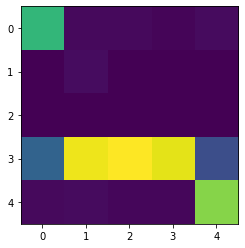

0.5126666666666667


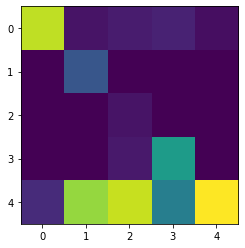

0.71


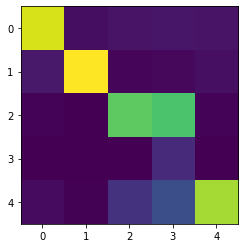

In [519]:
ratio = [0.5, 0.3, 0.2]
for r in ratio:
    x1, y_train, x2, y_test = dataset(documents, r)
    class_tf = TF(word_list, word_dict, x1)
    class_cf, class_icf = CF(word_list)
    tf_icf = TFICF(class_tf, class_icf)
    x_train, x_test = feature_selection(x1,x2,y_train,y_test,tf_icf, documents)
    nb = NaiveBayes()
    nb.fit(x_train, y_train)
    predict = nb.predict(x_test)
    acc, matrix = nb.accuracy(predict,y_test)
    print(acc)
    plt.imshow(matrix)
    plt.show()